In [26]:
import pandas as py
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

In [27]:
df = py.read_csv(r'D:\ML\BTP\preprocessing\final_batsmen.csv')

In [28]:
with open('striker_encoder.pkl', 'rb') as file:
    st = pickle.load(file)
with open('venue_encoder.pkl', 'rb') as file:
    vn = pickle.load(file)
with open('bowling_team_encoder.pkl', 'rb') as file:
    op = pickle.load(file)
df['striker'] = st.fit_transform(df['striker'])
df['venue'] = vn.fit_transform(df['venue'])
df['bowling_team'] = op.fit_transform(df['bowling_team'])

In [29]:
y = df.pop('dream 11 score')
X = df
# X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [30]:
parameters = {'loss_function': ['RMSE','MAE'],
                      'depth': [4, 6, 8],
                      'learning_rate': [0.01, 0.05, 0.1],
                      'iterations': [30, 100, 300, 1000],
                      'l2_leaf_reg': [.1, 1, 10, 100],
                      'early_stopping_rounds': [100],
                      'random_strength': [1],
                      'od_type': ['IncToDec'],
                      'random_seed': [1],
                      'use_best_model': [True]}


catboost_model = CatBoostRegressor()

In [31]:
cat_grid = RandomizedSearchCV(catboost_model,
                                parameters,
                                cv=4,
                                n_jobs=4)

In [32]:
cat_grid.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)

0:	learn: 28.9831784	test: 29.1337940	best: 29.1337940 (0)	total: 11.2ms	remaining: 3.36s
1:	learn: 28.5430524	test: 28.6924435	best: 28.6924435 (1)	total: 20ms	remaining: 2.98s
2:	learn: 28.1189848	test: 28.2744999	best: 28.2744999 (2)	total: 27.2ms	remaining: 2.69s
3:	learn: 27.7582189	test: 27.9295497	best: 27.9295497 (3)	total: 33.5ms	remaining: 2.48s
4:	learn: 27.4303637	test: 27.6178084	best: 27.6178084 (4)	total: 39.3ms	remaining: 2.32s
5:	learn: 27.1309461	test: 27.3352212	best: 27.3352212 (5)	total: 46.9ms	remaining: 2.3s
6:	learn: 26.8253208	test: 27.0247358	best: 27.0247358 (6)	total: 54.8ms	remaining: 2.29s
7:	learn: 26.5225910	test: 26.7253118	best: 26.7253118 (7)	total: 62.2ms	remaining: 2.27s
8:	learn: 26.2655453	test: 26.4722219	best: 26.4722219 (8)	total: 70ms	remaining: 2.26s
9:	learn: 25.9994795	test: 26.2159965	best: 26.2159965 (9)	total: 78.1ms	remaining: 2.26s
10:	learn: 25.7819975	test: 26.0043147	best: 26.0043147 (10)	total: 86.3ms	remaining: 2.27s
11:	learn: 25

RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000020885677130>,
                   n_jobs=4,
                   param_distributions={'depth': [4, 6, 8],
                                        'early_stopping_rounds': [100],
                                        'iterations': [30, 100, 300, 1000],
                                        'l2_leaf_reg': [0.1, 1, 10, 100],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'loss_function': ['RMSE', 'MAE'],
                                        'od_type': ['IncToDec'],
                                        'random_seed': [1],
                                        'random_strength': [1],
                                        'use_best_model': [True]})

In [33]:
best_random_grid=cat_grid.best_estimator_

In [34]:
y_pred = best_random_grid.predict(X_test)

In [35]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import r2_score

In [36]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


r2 = r2_score(y_test, y_pred)
print("r2 is:", r2)

Mean Squared Error: 496.25890668447795
r2 is: 0.43183256636259737


In [37]:
pickle.dump(best_random_grid, open('cat.pkl', 'wb'))

Text(0, 0.5, 'Features')

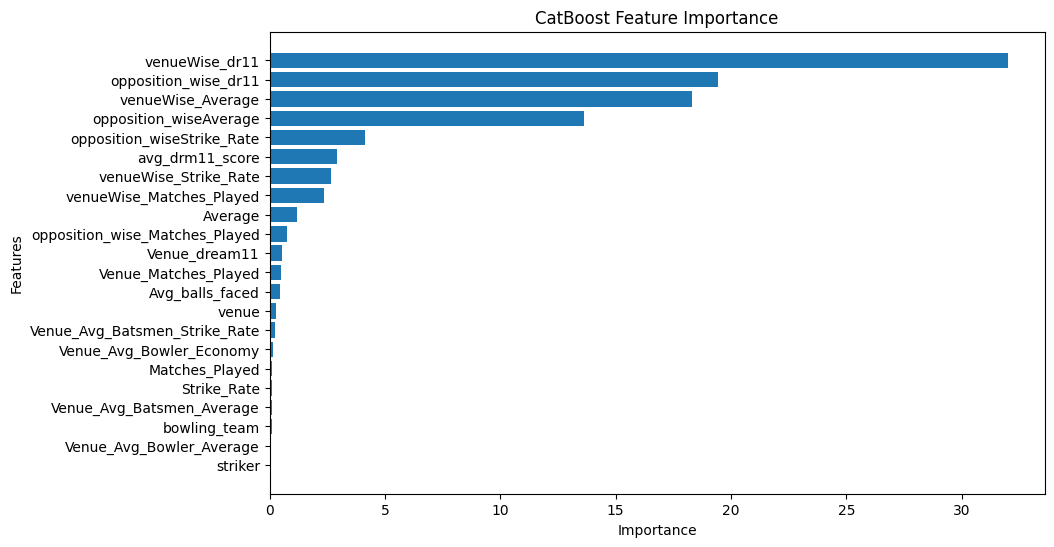

In [38]:
import matplotlib.pyplot as plt
importances = best_random_grid.get_feature_importance(type='PredictionValuesChange')
feature_importances = py.Series(importances, index=X.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

In [39]:
import shap

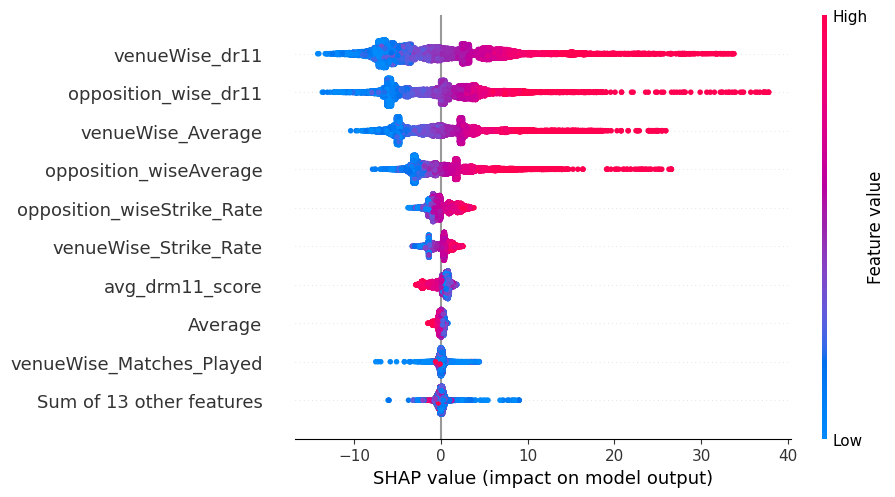

In [40]:
explainer = shap.TreeExplainer(best_random_grid)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)